# Setup (same everywhere)

## Mount Drive


In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

/content/drive/My Drive/repositories/moleculenet/notebooks


In [176]:
%ls

colab_extended_GPflow_regression.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_gp_ci.ipynb
colab_reproducing_grid_search_pipeline.ipynb
colab_reproducing_rf_ci.ipynb
eda.ipynb
visualise_extended_grid_search_results.ipynb
visualise_reproducing_grid_search_results.ipynb


In [177]:
%ls ../data/

esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original.csv
esol_original_extra_features.csv
esol_original_IdSmilesLabels.csv
esol_original_rdkit_features.csv
ESOL_README
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
FreeSolv_README
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv
Lipo_README


## Import modules

### Standard imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# custom imports
import os
import sys

# saving models
import json
import pickle

# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

# making custom metrics
from sklearn.metrics import make_scorer

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

# pipelines
# https://scikit-learn.org/stable/modules/compose.html#combining-estimators
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
try:
    import forestci as fci
    print("Successful import")
except ImportError as e:
    ! pip install forestci
    import forestci as fci

Failed to import duecredit due to No module named 'duecredit'


Successful import


In [3]:
import sklearn
print(sklearn.__version__)
print(fci.__version__)

0.23.1
0.4.1


### Custom imports

In [4]:
sys.path.insert(0, '..')

# preprocessing
from util_scripts.preprocessing_functions import list_highly_correlated

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels

sys.path.insert(0, './notebooks')

In [5]:
help(list_highly_correlated)

Help on function list_highly_correlated in module util_scripts.preprocessing_functions:

list_highly_correlated(df_features, targets, threshold=0.8)
    List column names of the dataframe of features which are highly correlated
    to the target (absolute value of the correlation is greater than the threshold).
    
    Parameters
    ----------
    df_features : (n, p) pandas.core.frame.DataFrame of p features
                  Input array.
    targets     : (n,) pandas.core.series.Series of targets
                  Input array.
    threshold   : float in [0, 1] above which we consider a feature highly correlated
    
    Returns
    -------
    cols_to_remove : list of column names from df_features, which are highly correlated
                     to the target



## Set plotting style

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# Load Data (same everywhere)

## CHOOSE: dataset, smile_type, grid_search_type

In [29]:
dataset = 'lipophilicity'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'reproducing'
assert grid_search_type in ['reproducing', 'extended']

In [8]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [9]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


## Load Features and Targets

Leave all features here so setup and Load and prepare data are the same everywhere.

In [10]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmilesLabels.csv', index_col=0)
# labels
labels = id_smile_target['labels']

In [11]:
# fingerprints
ecfp4_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp4_features.csv', index_col=0)
ecfp6_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp6_features.csv', index_col=0)

ecfp4_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp4_features.csv', index_col=0)
ecfp6_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp6_features.csv', index_col=0)

In [12]:
# RDKit descriptors
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)

highly_correlated_features = list_highly_correlated(rdkit_features, labels, threshold=0.75)

print(f'\nRemoving {len(highly_correlated_features)} highly correlated feature(s).')
rdkit_features = rdkit_features.drop(highly_correlated_features, axis=1)


Found 0 highly-correlated feature(s):
[]

Removing 0 highly correlated feature(s).


In [13]:
print('rdkit_features.shape:      ', rdkit_features.shape)
print('ecfp4_1024_features.shape: ', ecfp4_1024_features.shape)
print('ecfp6_1024_features.shape: ', ecfp6_1024_features.shape)
print('ecfp4_2048_features.shape: ', ecfp4_2048_features.shape)
print('ecfp6_2048_features.shape: ', ecfp6_2048_features.shape)
print('labels.shape:              ', labels.shape)

rdkit_features.shape:       (642, 200)
ecfp4_1024_features.shape:  (642, 1024)
ecfp6_1024_features.shape:  (642, 1024)
ecfp4_2048_features.shape:  (642, 2048)
ecfp6_2048_features.shape:  (642, 2048)
labels.shape:               (642,)


In [14]:
labels.head()

id
4-methoxy-N,N-dimethyl-benzamide   -11.01
methanesulfonyl chloride            -4.87
3-methylbut-1-ene                    1.83
2-ethylpyrazine                     -5.45
heptan-1-ol                         -4.21
Name: labels, dtype: float64

## Create one DataFrame with all features

In [15]:
all_features = pd.concat([rdkit_features,
                          ecfp4_1024_features, ecfp6_1024_features,
                          ecfp4_2048_features, ecfp6_2048_features],
                         axis='columns')

In [16]:
all_features.shape

(642, 6344)

In [17]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,2048ecfp6-2038,2048ecfp6-2039,2048ecfp6-2040,2048ecfp6-2041,2048ecfp6-2042,2048ecfp6-2043,2048ecfp6-2044,2048ecfp6-2045,2048ecfp6-2046,2048ecfp6-2047
"4-methoxy-N,N-dimethyl-benzamide",12.428170,-3.458874,12.428170,0.519264,0.686360,179.219,166.115,179.094629,70.0,0.0,...,0,0,0,0,0,0,0,0,0,0
methanesulfonyl chloride,9.855710,-4.368056,9.855710,3.074846,0.421427,114.553,111.529,113.954228,32.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3-methylbut-1-ene,7.349537,-3.289005,7.349537,1.280324,0.412737,70.135,60.055,70.078250,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2-ethylpyrazine,7.363796,-3.006484,7.363796,0.587878,0.536795,108.144,100.080,108.068748,42.0,0.0,...,0,0,0,0,0,0,0,0,0,0
heptan-1-ol,7.581250,-4.173333,7.581250,3.423878,0.544191,116.204,100.076,116.120115,50.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# CHOOSE: what feature_sets we will iterate over

## Put original features into feature_sets
Create a dictionary containing feature names (index objects) as its elements

In [18]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    '1024ecfp-4': ecfp4_1024_features.columns,
    '1024ecfp-6': ecfp6_1024_features.columns,
    '2048ecfp-4': ecfp4_2048_features.columns,
    '2048ecfp-6': ecfp6_2048_features.columns,
}

## Adding a combination of RDKit features with every feature set in the feature_sets dictionary


In [19]:
for f in ['1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])

In [20]:
list(feature_sets.keys())

['RDKit',
 '1024ecfp-4',
 '1024ecfp-6',
 '2048ecfp-4',
 '2048ecfp-6',
 '1024ecfp-4 + RDKit',
 '1024ecfp-6 + RDKit',
 '2048ecfp-4 + RDKit',
 '2048ecfp-6 + RDKit']

# List of estimators

In [21]:
estimators = {
    'rf':  RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'krr': KernelRidge(kernel='rbf'), # 'rbf' used in the paper (defaults to 'linear')
    'gp': GaussianProcessRegressor(normalize_y=True), # normilize since we have not normalized here
}

## Load best parameters

In [26]:
f'../results/{dataset}_{smile_type}_{grid_search_type}_random_search_best_params.pickle'

'../results/esol_original_reproducing_random_search_best_params.pickle'

In [27]:
with open(f'../results/{dataset}_{smile_type}_{grid_search_type}_random_search_best_params.pickle', 'rb') as fp:
    best_params = pickle.load(fp)

In [28]:
best_params

{'1024ecfp-4': {'rf': {'rf__n_estimators': 500},
  'xgb': {'xgb__n_estimators': 350,
   'xgb__max_depth': 3,
   'xgb__learning_rate': 0.3},
  'krr': {'krr__alpha': 0.01},
  'gp': {'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)}}}

# Getting CIs for the best combination feature-set * estimator

In [201]:
# feature set - choose differently when extended
f = '1024ecfp-4'

In [202]:
X = all_features[feature_sets[f]]
y = labels[X.index]

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [204]:
y_train

N,N-dimethylformamide                         -7.81
2-chloro-2-methyl-propane                      1.09
1,2-dinitroxyethane                           -5.73
2-propoxyethanol                              -6.40
pentyl propanoate                             -2.11
                                              ...  
1-(2-hydroxyethylamino)-9,10-anthraquinone   -14.21
hexa-1,5-diene                                 1.01
cumene                                        -0.30
diethoxymethoxybenzene                        -5.23
hexan-3-ol                                    -4.06
Name: labels, Length: 513, dtype: float64

## Run GP with best parameters on the selected feature set

In [205]:
e = 'gp'

In [206]:
best_params[f][e]['gp__kernel']

Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)

In [224]:
gpr = GaussianProcessRegressor(kernel=best_params[f][e]['gp__kernel'],
                               random_state=0, n_restarts_optimizer=2)

gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [230]:
y_test_pred, y_test_std = gpr.predict(X_test, return_std=True)
y_train_pred, y_train_std = gpr.predict(X_train, return_std=True)

## Plot the results for test and train observations

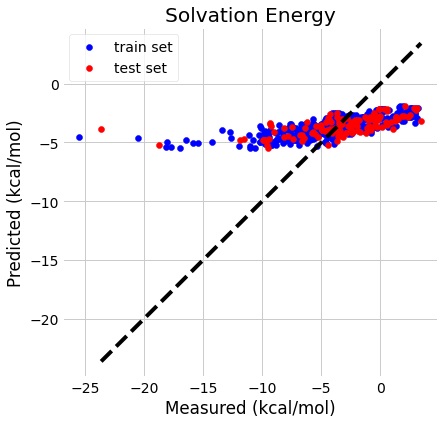

In [231]:
# Plot predicted logD without error bars
plt.figure(figsize=FIGSIZE_CI)
plt.tight_layout()

plt.scatter(y_train, y_train_pred, color='blue', label='train set')
plt.scatter(y_test, y_test_pred, color='red', label='test set')

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

plt.legend()

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

# Confidence Intervals

## Calculate confidence bounds using std part of gpr predictions

In [227]:
len(y_test_pred)

129

In [214]:
upper = y_test_pred + 1.96 * y_test_std[1]
lower = y_test_pred - 1.96 * y_test_std[1]

In [215]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper}
)
CIs_df = CIs_df.sort_values(by='y_test')

## Plot test observations with error bars (1 std.)

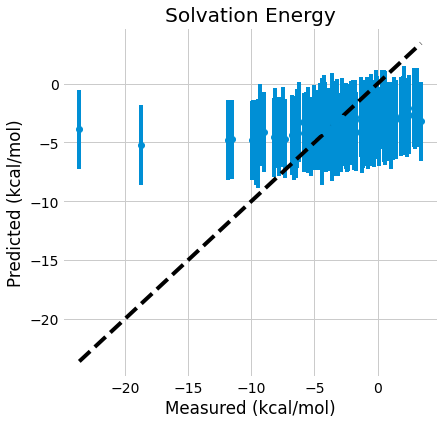

In [216]:
# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.errorbar(x=CIs_df.y_test, y=CIs_df.y_test_pred, yerr=CIs_df.y_test_std, fmt='o')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

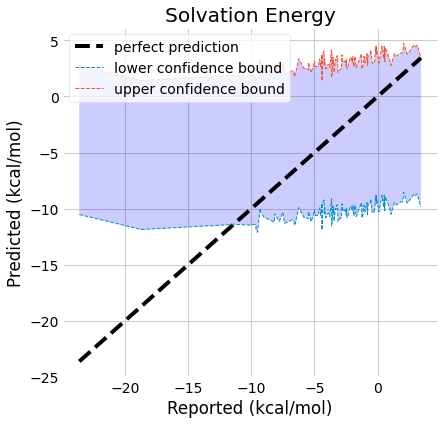

In [220]:
fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)

ax.set_xlabel(f'Reported {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.set_title(f'{datasets_to_titles[dataset]}')
ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

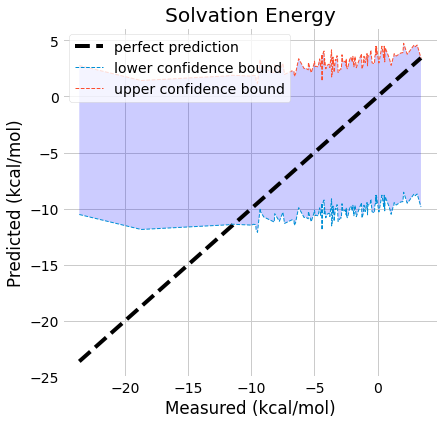

In [221]:
plt.figure(figsize=FIGSIZE_CI)

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

plt.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
plt.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
plt.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

plt.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [222]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis

(2R,3R,4R,5R)-Hexan-1,2,3,4,5,6-hexol    False
5-iodouracil                             False
1,4-diamino-9,10-anthracenedione         False
2-amino-9,10-anthraquinone               False
acetylsalicylic acid                      True
                                         ...  
3-methylpentane                           True
octane                                    True
3-methylheptane                           True
nonane                                    True
octafluorocyclobutane                    False
Length: 129, dtype: bool

In [223]:
within_cis.sum() / len(within_cis)

0.9612403100775194